In [1]:
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np 
from statistics import mean
from sklearn.preprocessing import MinMaxScaler 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import seaborn as sns
import networkx as nx

In [2]:
df = pd.DataFrame()
f = yf.download(tickers = "RELIANCE.NS",
                       start = '2022-01-01',
                       end = '2022-06-01',)

#df = f[[("Adj Close", s) for s in list_of_stocks]]
df = f[["Adj Close"]]
#df.columns = df.columns.droplevel(level=0)
df

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2022-01-03,2396.634521
2022-01-04,2450.721680
2022-01-05,2462.187012
2022-01-06,2409.246338
2022-01-07,2428.687988
...,...
2022-05-25,2604.159668
2022-05-26,2579.334473
2022-05-27,2567.370361


In [3]:
#convert to numpy array for neurl network to take input 

#print(type(df))
training_set = f.iloc[:,4:5].values
#print(type(df))

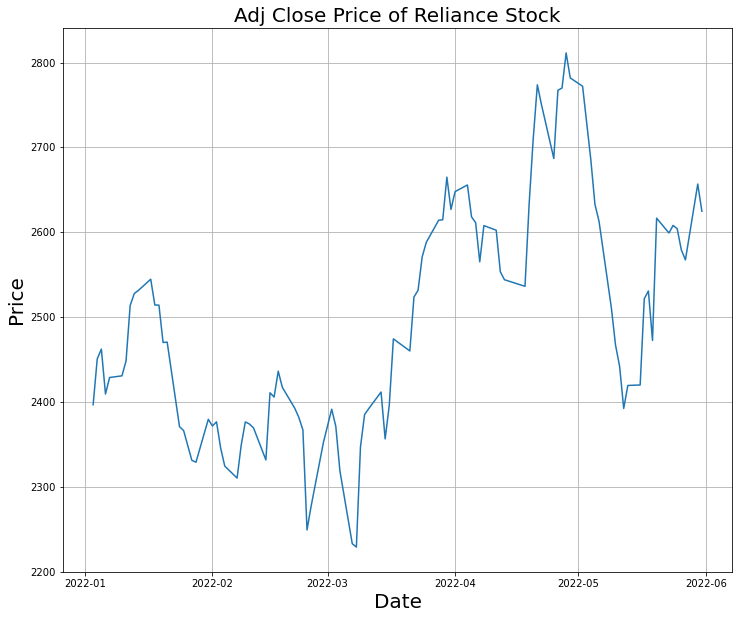

In [4]:
plt.figure(figsize=(12,10))
plt.plot(df)
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Price", fontsize = 20)
plt.title("Adj Close Price of Reliance Stock", fontsize = 20)
plt.grid(True)
plt.show()

In [5]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler
training_set_scaled = scaler.fit_transform(training_set)

In [6]:
#Lag = 15 -( 3 weeks )
#Train the model on 15 day data
x_train_a = []
y_train_a = []
for i in range(15, len(training_set_scaled)):
    x_train_a.append(training_set_scaled[i-15: i, 0])
    y_train_a.append(training_set_scaled[i])

x_train_a, y_train_a = np.array(x_train_a), np.array(y_train_a)

In [7]:
N = len(y_train_a)

In [8]:
N #Total number of inputs

86

In [9]:
x_train_a.shape

(86, 15)

In [10]:
 ## make model 
# instntiate model
my_model = Sequential()

# add layers 

#layer 1
my_model.add(SimpleRNN(units = 50, return_sequences = True, activation = "relu", input_shape = (x_train_a.shape[1] ,1)))
my_model.add(Dropout(rate = 0.2))

#layer 2
my_model.add(SimpleRNN(units = 50, return_sequences = True, activation = "relu"))
my_model.add(Dropout(rate = 0.2))


#layer 3
my_model.add(SimpleRNN(units = 50, return_sequences = True, activation = "relu"))
my_model.add(Dropout(rate = 0.2))

#layer 4
my_model.add(SimpleRNN(units = 50, return_sequences = False, activation = "relu"))
my_model.add(Dropout(rate = 0.2))

#output layer 
my_model.add(Dense(units = 1))

## compile model 
my_model.compile(optimizer = "adam", loss = "mean_squared_error")
    

In [11]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 15, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 15, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 15, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 15, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 15, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 15, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5

## Fit Model

In [12]:
# METHOD 1: ONLY SAVES 1 LAYER, ALL WEIGHTS 
# use callback function to get weights after every epoch 
from keras.callbacks import Callback

class CollectWeightCallback(Callback):
    def __init__(self, layer_index):
        super(CollectWeightCallback, self).__init__()
        self.layer_index = layer_index
        self.weights = []

    def on_epoch_end(self, epoch, logs=None):
        layer = self.model.layers[self.layer_index]
        self.weights.append(layer.get_weights()[0]) # [0] - get weight only, no biases

In [13]:
numEpochs = 100
numBatch = 20

In [14]:
cbk0 = CollectWeightCallback(layer_index=0) # 0 = 1st layer 
cbk2 = CollectWeightCallback(layer_index=2) # 2 = 2nd layer or 1st dense layer 
cbk4 = CollectWeightCallback(layer_index=4) # 4 = 3rd layer or 2nd dense layer 
cbk6 = CollectWeightCallback(layer_index=6) # 6 = 4th layer or 3rd dense layer 
cbk8 = CollectWeightCallback(layer_index=8) # 8 = last layer 
my_model.fit(x_train_a, y_train_a, epochs = numEpochs, callbacks=[cbk0, cbk2, cbk4, cbk6, cbk8], batch_size = numBatch)

Epoch 1/100
5/5 [==============================] - 3s 12ms/step - loss: 0.0861
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0747
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0561
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0328
Epoch 5/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0318
Epoch 6/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0312
Epoch 7/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0304
Epoch 8/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0291
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0314
Epoch 10/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0337
Epoch 11/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0265
Epoch 12/100
5/5 [==============================] - 0s 12ms/step - loss: 0.0252
Epoch 13/100
5/5 [==============================] - 0

## Get Weights 

Make Indices

In [15]:
m = 50 # no. of neurons in a hidden layer 
p = 50
index_neuron = [] 
weights_neuron = []
for i in range(50):
    index_neuron.append("Neuron " + str(i+1))
    weights_neuron.append("W" + str(i+1))

In [16]:
n = 0 # weights for n+1th epoch
# hidden layer 1
df01 = pd.DataFrame(cbk2.weights[n], index = index_neuron , columns = weights_neuron)
df01 = df01.transpose()
# hidden layer 2
df02 = pd.DataFrame(cbk4.weights[n], index = index_neuron , columns = weights_neuron)
df02 = df02.transpose()
# hidden layer 3
df03 = pd.DataFrame(cbk6.weights[n], index = index_neuron , columns = weights_neuron)
df03 = df03.transpose()

#### Checking correlation among different layers 

In [17]:
new_df01 = [df01, df02, df03]
df_layer = pd.concat(new_df01, axis = 1, keys = ["L1", "L2", "L3"])

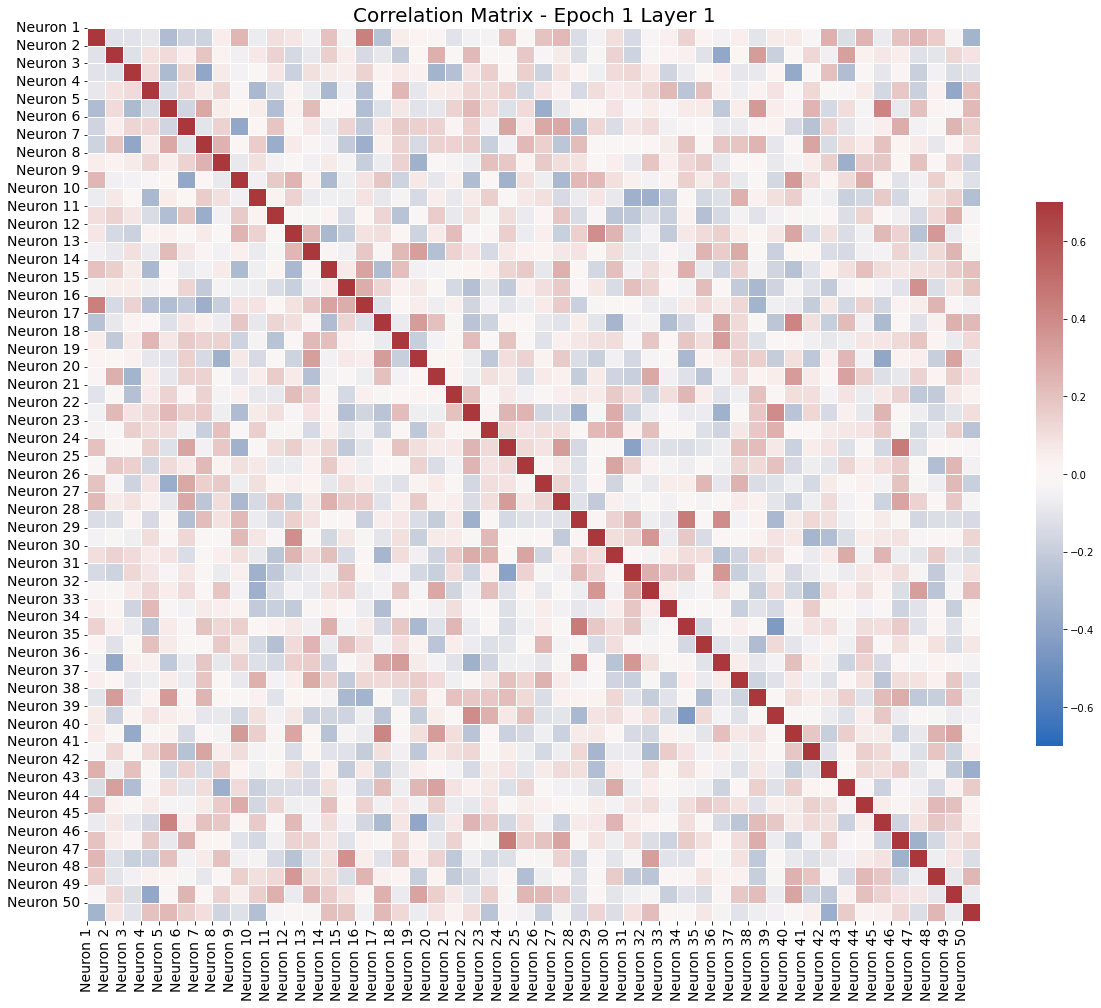

In [18]:
cor_mat01 = df01.corr() # correlations
f, ax = plt.subplots(figsize = (20,20)) # figure
cmap = sns.color_palette("vlag", as_cmap = True) # colour 
sns.heatmap(
    cor_mat01, # correlations
    cmap = cmap, # colour 
    #annot = True, # show values in cells? 
    vmax = 0.7, # max value on legend, >= .7 will be same color
    vmin = -0.7, # min value on the legend, <= .7 will be same color 
    square = True, # Force cells to be square 
    linewidth = .5, # width of lines that divide cells 
    cbar_kws = {"shrink": .5}
)
plt.xticks(range(df01.select_dtypes(['number']).shape[1]), df01.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df01.select_dtypes(['number']).shape[1]), df01.select_dtypes(['number']).columns, fontsize=14)
plt.title('Correlation Matrix - Epoch 1 Layer 1', fontsize=20);

In [19]:
n = 99 # weights for n+1th epoch
# hidden layer 1
df99 = pd.DataFrame(cbk2.weights[n], index = index_neuron , columns = weights_neuron)
df99 = df99.transpose()

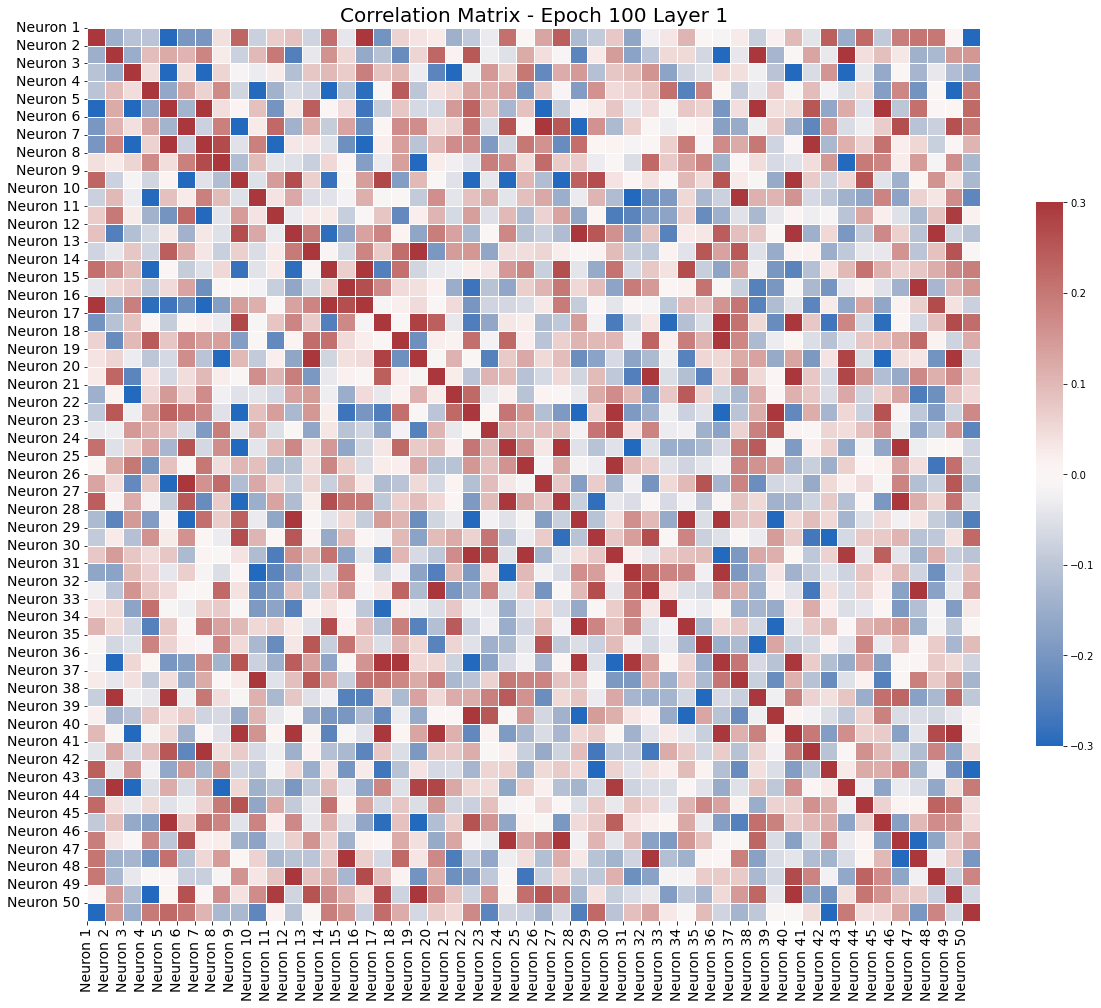

In [20]:
cor_mat = df99.corr() # correlations
f, ax = plt.subplots(figsize = (20,20)) # figure
cmap = sns.color_palette("vlag", as_cmap = True) # colour 
sns.heatmap(
    cor_mat, # correlations
    cmap = cmap, # colour 
    #annot = True, # show values in cells? 
    vmax = 0.3, # max value on legend, >= .7 will be same color
    vmin = -0.3, # min value on the legend, <= .7 will be same color 
    square = True, # Force cells to be square 
    linewidth = .5, # width of lines that divide cells 
    cbar_kws = {"shrink": .5}
)
plt.xticks(range(df99.select_dtypes(['number']).shape[1]), df99.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df99.select_dtypes(['number']).shape[1]), df99.select_dtypes(['number']).columns, fontsize=14)
plt.title('Correlation Matrix - Epoch 100 Layer 1', fontsize=20);

Graph of Neurons in Layer 1 Epoch 1

### Graphs

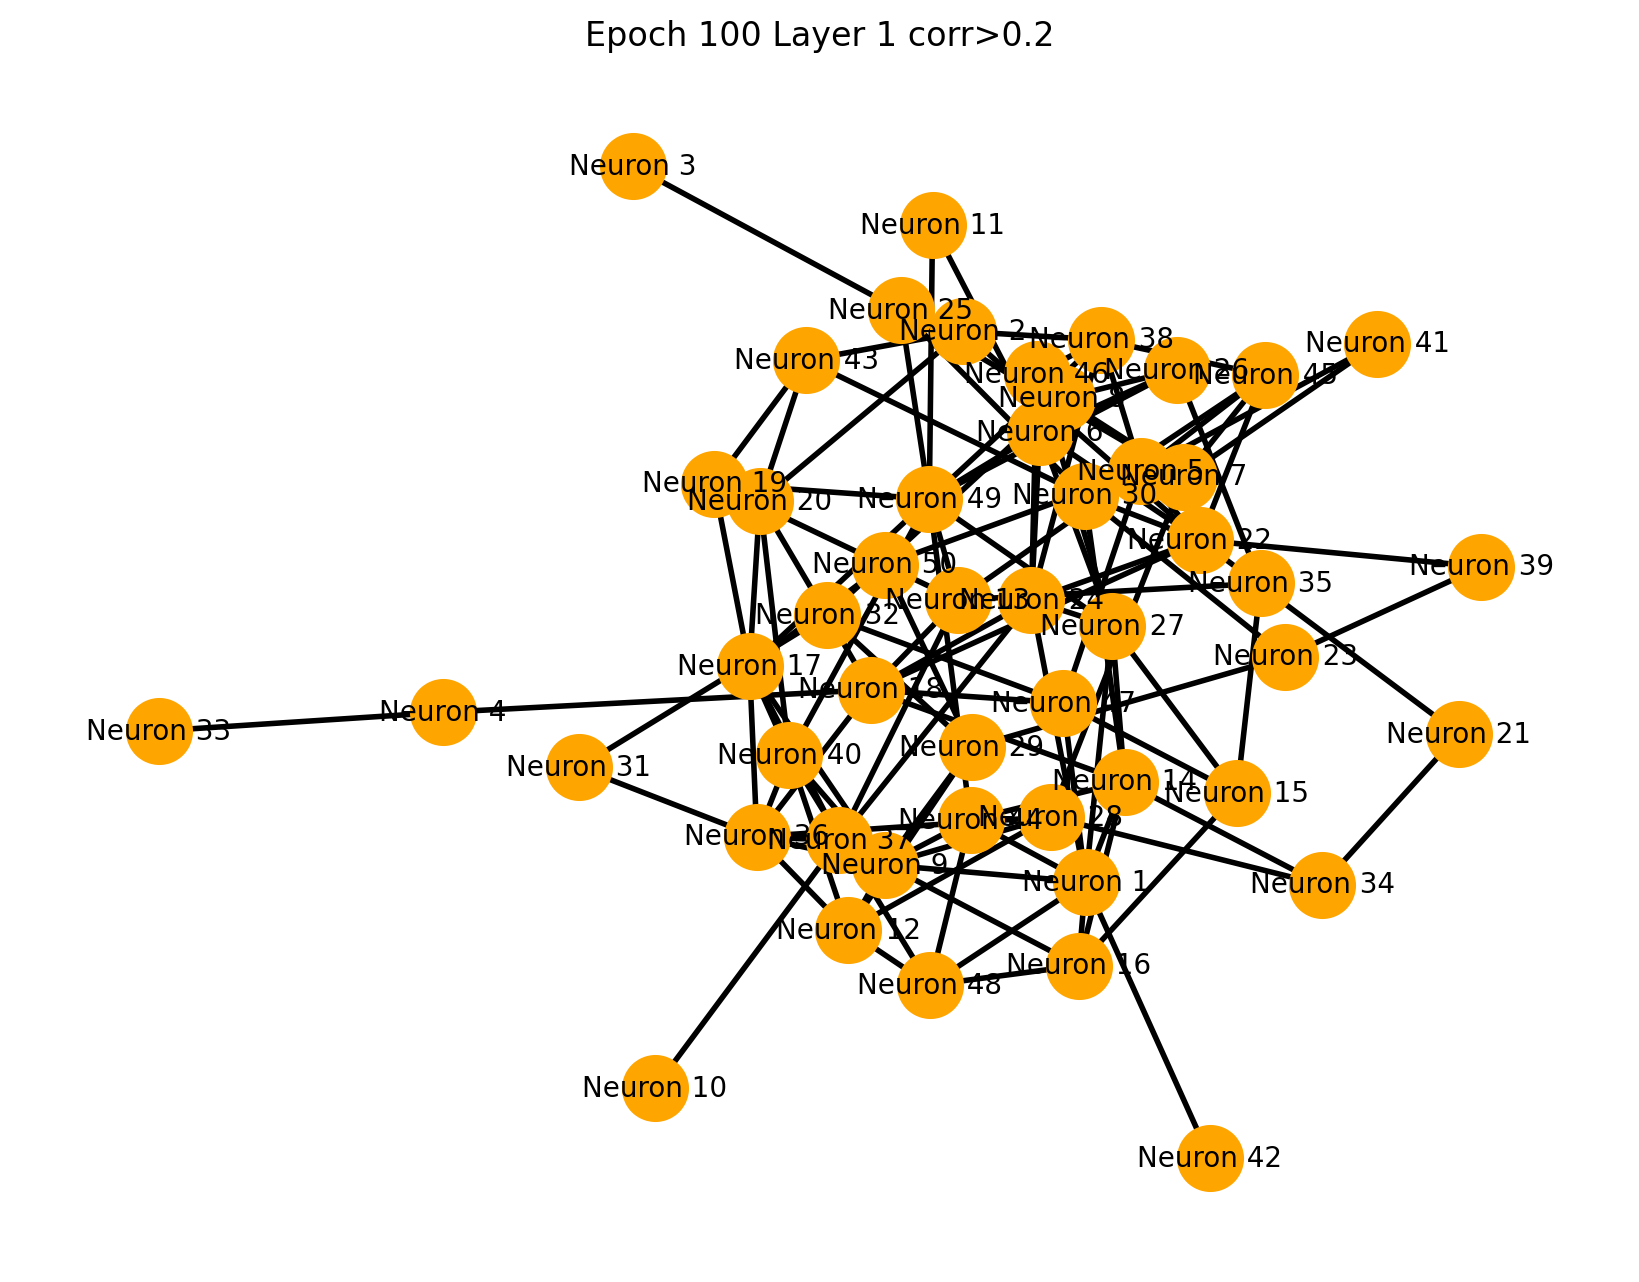

In [21]:
# make an edge list 

# converts lower triangular matrix to 0
cor_mat= cor_mat.mask(np.tril(np.ones(cor_mat.shape)).astype(np.bool_), 0) 

# creating edge list 
links = cor_mat.stack().reset_index()
links.columns = ['Neuron A', 'Neuron B', 'Value'] 
#drop the rows with 0 in Value 
rows_zero = links.loc[links['Value'] == 0.0]
links = links.drop(rows_zero.index)

# save values with correlation more than 0.2
links_filtered=links.loc[ (links['Value'] > abs(0.2)) ]

# make the graph 
G=nx.from_pandas_edgelist(links_filtered, 'Neuron A', 'Neuron B')
pos = nx.spring_layout(G)
#pos = nx.spectral_layout(G) 
# spectral layout helps us see how the community structure or other forms of structure in the graph. 
# It uses eigen vectors and eigen values to position the nodes. 

# plot the graph 
plt.figure(figsize=(8,6), dpi=200)
nx.draw(G, pos, with_labels=True, node_color='orange', width = 2, edge_color='black', linewidths=10, font_size=10, node_size = 200)
plt.title('Epoch 100 Layer 1 corr>0.2')
plt.show()

In [22]:
# make network grah
def make_graph(corr_mat, correlation_value):
    
    # make a for loop for graph layout
    p = correlation_value
    cor_mat = corr_mat
    # make an edge list 

    # converts lower triangular matrix to 0
    cor_mat= cor_mat.mask(np.tril(np.ones(cor_mat.shape)).astype(np.bool_), 0) 

    # creating edge list 
    links = cor_mat.stack().reset_index()
    links.columns = ['Neuron A', 'Neuron B', 'Value'] 
    #drop the rows with 0 in Value 
    rows_zero = links.loc[links['Value'] == 0.0]
    links = links.drop(rows_zero.index)

    # save values with correlation more than 0.2
    links_filtered=links.loc[ (links['Value'] > abs(p)) ]

    # make the graph 
    G=nx.from_pandas_edgelist(links_filtered, 'Neuron A', 'Neuron B')
    pos = nx.spring_layout(G)
    #pos = nx.spectral_layout(G) 
    # spectral layout helps us see how the community structure or other forms of structure in the graph. 
    # It uses eigen vectors and eigen values to position the nodes. 

    # plot the graph 
    plt.figure(figsize=(8,6), dpi=200)
    nx.draw(G, pos, with_labels=True, node_color='orange', width = 2, edge_color='black', linewidths=10, font_size=10, node_size = 200)
    plt.title('Epoch 100 Layer 1 corr>0.2')
    plt.show()

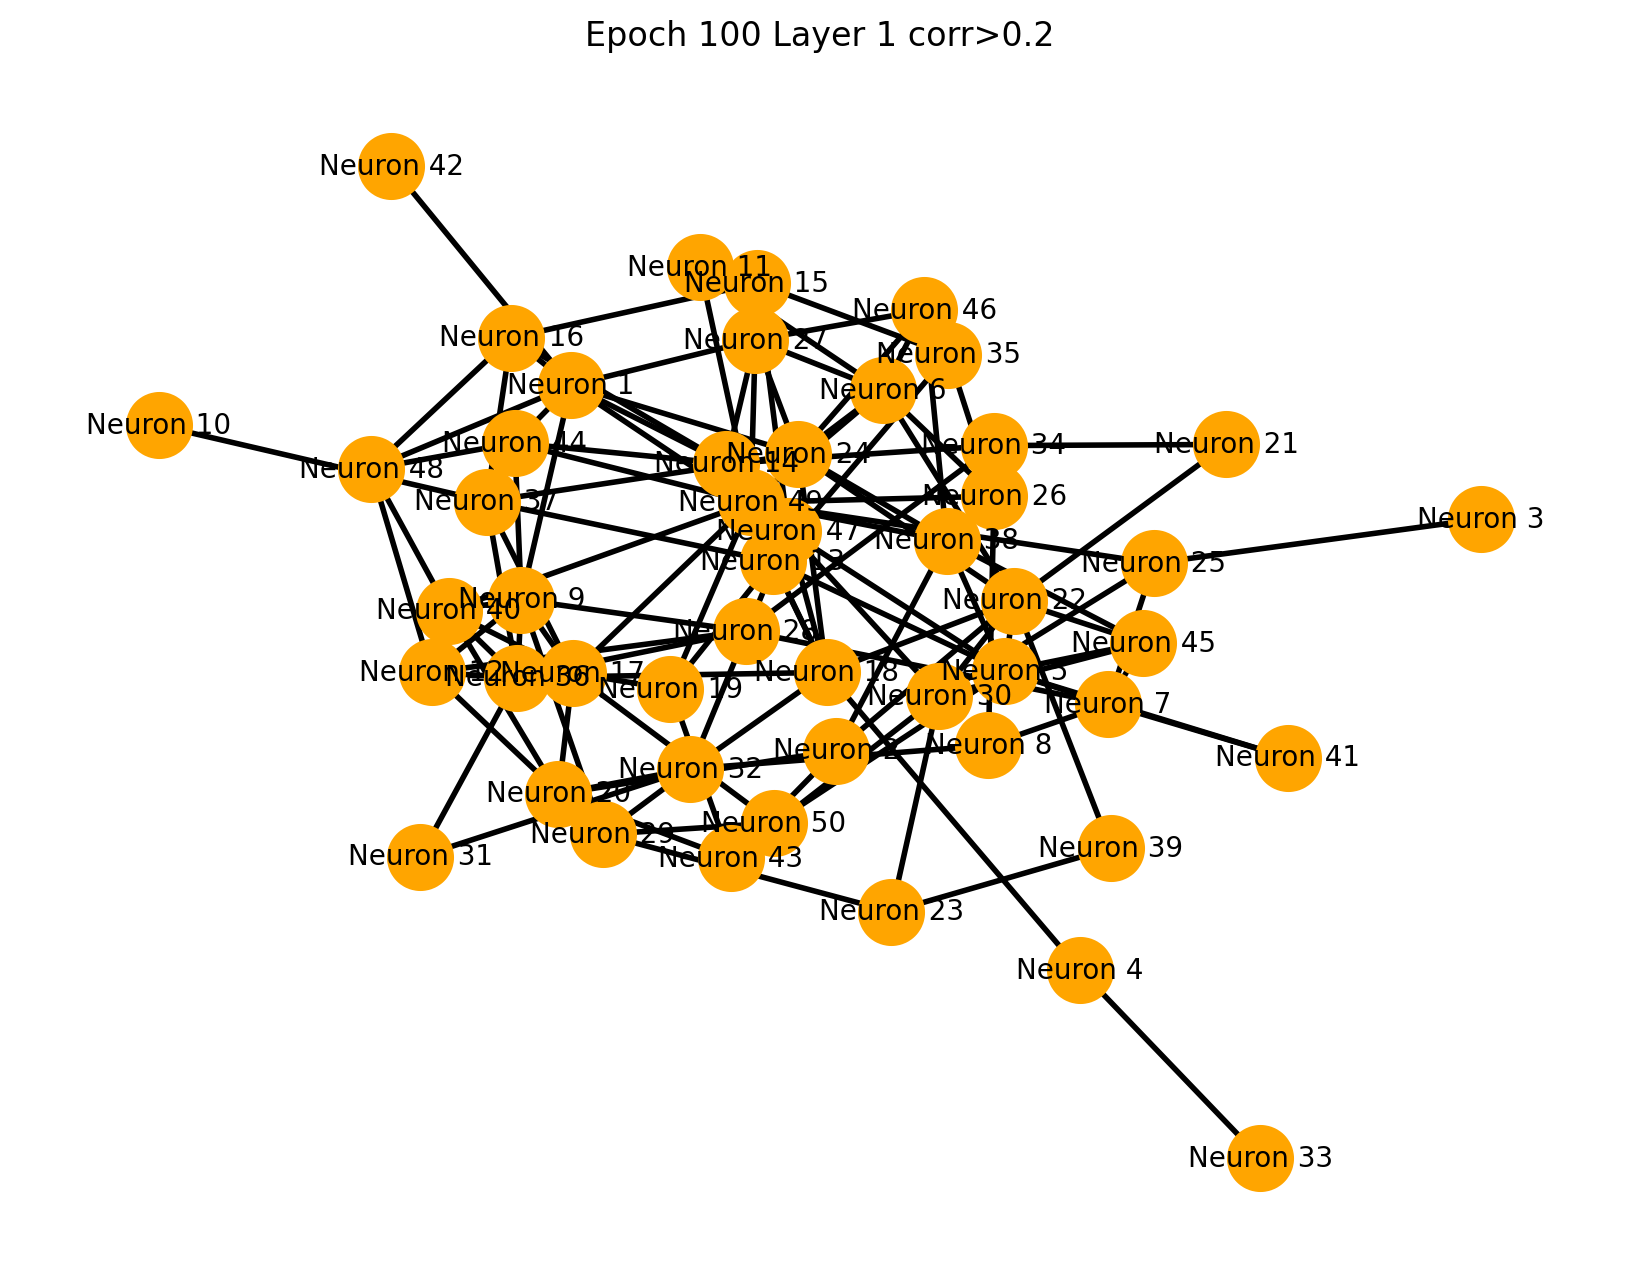

In [23]:
make_graph(cor_mat, 0.2)

[[{'Neuron 39', 'Neuron 42', 'Neuron 47', 'Neuron 24', 'Neuron 6', 'Neuron 14', 'Neuron 37', 'Neuron 50', 'Neuron 34', 'Neuron 19', 'Neuron 16', 'Neuron 32', 'Neuron 10', 'Neuron 35', 'Neuron 28', 'Neuron 45', 'Neuron 36', 'Neuron 5', 'Neuron 23', 'Neuron 18', 'Neuron 38', 'Neuron 49', 'Neuron 12', 'Neuron 7', 'Neuron 29', 'Neuron 9', 'Neuron 13', 'Neuron 25', 'Neuron 46', 'Neuron 30', 'Neuron 20', 'Neuron 15', 'Neuron 17', 'Neuron 26', 'Neuron 1', 'Neuron 22', 'Neuron 40', 'Neuron 11', 'Neuron 21', 'Neuron 2', 'Neuron 27', 'Neuron 8', 'Neuron 48', 'Neuron 43', 'Neuron 41', 'Neuron 31', 'Neuron 3', 'Neuron 44'}, {'Neuron 33', 'Neuron 4'}], [{'Neuron 39', 'Neuron 42', 'Neuron 47', 'Neuron 24', 'Neuron 6', 'Neuron 14', 'Neuron 37', 'Neuron 50', 'Neuron 34', 'Neuron 19', 'Neuron 16', 'Neuron 32', 'Neuron 10', 'Neuron 35', 'Neuron 28', 'Neuron 45', 'Neuron 36', 'Neuron 5', 'Neuron 23', 'Neuron 18', 'Neuron 38', 'Neuron 49', 'Neuron 12', 'Neuron 7', 'Neuron 29', 'Neuron 9', 'Neuron 13', 'Ne

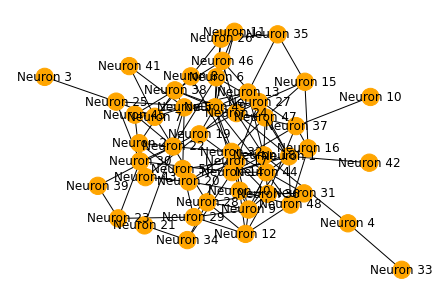

In [24]:
from networkx.algorithms.community.centrality import girvan_newman 
communities = girvan_newman(G)
node_groups = []
for com in (communities):
    node_groups.append(list(com))

#print(node_groups)

color_map = []
for node in G:
    if node in node_groups[0]:
        color_map.append("green")
    elif node in node_groups[1]:
        color_map.append("red")
    else:
        color_map.append("orange")
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

## Community Detection using Louvain - highest modularity

In [25]:
import community.community_louvain as community_louvain
# Detect communities using Louvain algorithm
partition = community_louvain.best_partition(G)

# Print the community membership of each node
#for node, community_id in partition.items():
#    print("Node", node, "belongs to community", community_id)

modularity = community_louvain.modularity(partition, G)
# print(modularity)

In [63]:
partition

{'Neuron 1': 0,
 'Neuron 9': 4,
 'Neuron 14': 0,
 'Neuron 16': 0,
 'Neuron 24': 2,
 'Neuron 27': 2,
 'Neuron 42': 0,
 'Neuron 44': 0,
 'Neuron 47': 3,
 'Neuron 48': 0,
 'Neuron 2': 1,
 'Neuron 20': 1,
 'Neuron 22': 5,
 'Neuron 38': 2,
 'Neuron 43': 1,
 'Neuron 3': 5,
 'Neuron 25': 5,
 'Neuron 4': 3,
 'Neuron 18': 3,
 'Neuron 33': 3,
 'Neuron 5': 5,
 'Neuron 7': 5,
 'Neuron 13': 1,
 'Neuron 41': 5,
 'Neuron 45': 5,
 'Neuron 50': 4,
 'Neuron 6': 2,
 'Neuron 11': 2,
 'Neuron 26': 3,
 'Neuron 46': 2,
 'Neuron 49': 2,
 'Neuron 8': 3,
 'Neuron 28': 4,
 'Neuron 32': 3,
 'Neuron 12': 4,
 'Neuron 17': 4,
 'Neuron 29': 4,
 'Neuron 36': 4,
 'Neuron 40': 4,
 'Neuron 10': 1,
 'Neuron 37': 1,
 'Neuron 19': 1,
 'Neuron 35': 3,
 'Neuron 30': 5,
 'Neuron 34': 0,
 'Neuron 15': 3,
 'Neuron 21': 0,
 'Neuron 39': 5,
 'Neuron 23': 5,
 'Neuron 31': 3}

In [26]:
# Prints the list of communities
new_dict = {}
for key, value in partition.items():
    new_dict.setdefault(value, []).append(key)

# Convert the dictionary of lists into a list of lists
result = list(new_dict.values())

In [65]:
len(result)

5

### Modularity - Using Louvain Algorithm

# The Modularity Function - Change over time - Layer 1

In [59]:
# Correlation matrix for every epoch of Hidden Layer 1
corr_mat_epoch = []
for n in range(numEpochs):
    df = pd.DataFrame(cbk2.weights[n], index = index_neuron , columns = weights_neuron)
    df = df.transpose() 
    df = df.corr()
    df = df.mask(np.tril(np.ones(df.shape)).astype(np.bool_), 0) 
    corr_mat_epoch.append(df)

In [67]:
# finding modularity for each matrix 
modularity_layer1 = []
communities_layer1 = []
for n in range(numEpochs):
    cor_mat = corr_mat_epoch[n]
        # creating edge list 
    links = cor_mat.stack().reset_index()
    links.columns = ['Neuron A', 'Neuron B', 'Value'] 
    # drop the rows with 0 in Value 
    rows_zero = links.loc[links['Value'] == 0.0]
    links = links.drop(rows_zero.index)

    # save values with correlation more than 0.2
    links_filtered=links.loc[ (links['Value'] > abs(0.2)) ]

    # make the graph 
    G=nx.from_pandas_edgelist(links_filtered, 'Neuron A', 'Neuron B')
    pos = nx.spring_layout(G) 

    # calculate modularity 
    # Detect communities using Louvain algorithm
    partition = community_louvain.best_partition(G)
    
    # list of communities
    new_dict = {}
    for key, value in partition.items():
        new_dict.setdefault(value, []).append(key)
    # Convert the dictionary of lists into a list of lists
    result = list(new_dict.values())
    
    communities_layer1.append(len(result))

    modularity = community_louvain.modularity(partition, G)
    
    modularity_layer1.append(modularity)

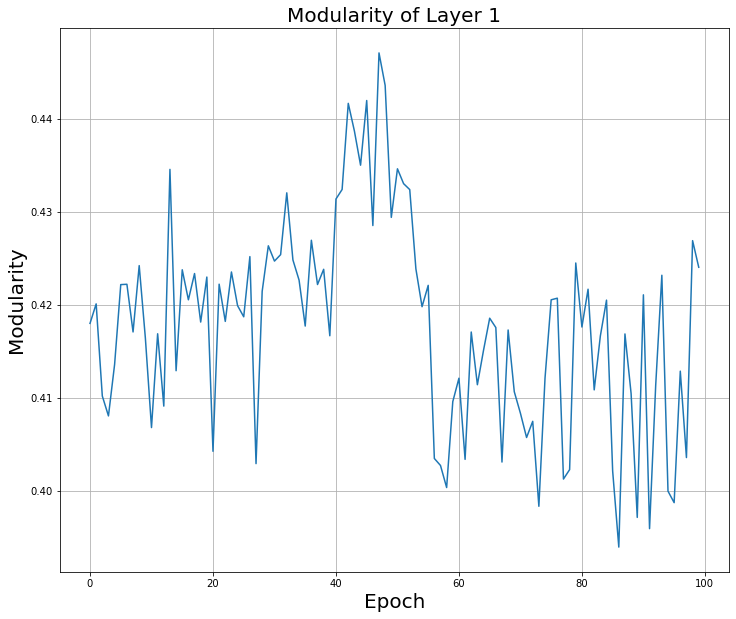

In [71]:
plt.figure(figsize=(12,10))
plt.plot(modularity_layer1)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Modularity", fontsize = 20)
plt.title("Modularity of Layer 1", fontsize = 20)
plt.grid(True)
plt.show()

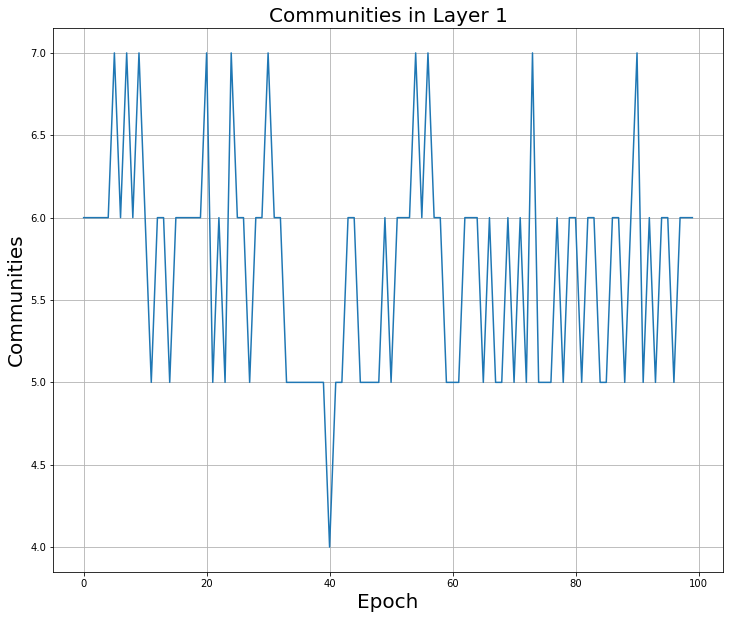

In [72]:
plt.figure(figsize=(12,10))
plt.plot(communities_layer1)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Communities", fontsize = 20)
plt.title("Communities in Layer 1", fontsize = 20)
plt.grid(True)
plt.show()

# Modularity - Layer 2  

In [85]:
# Correlation matrix for every epoch of Hidden Layer 1
corr_mat_epoch_l2 = []
for n in range(numEpochs):
    df = pd.DataFrame(cbk4.weights[n], index = index_neuron , columns = weights_neuron)
    df = df.transpose() 
    df = df.corr()
    df = df.mask(np.tril(np.ones(df.shape)).astype(np.bool_), 0) 
    corr_mat_epoch_l2.append(df)

In [86]:
# finding modularity for each matrix 
modularity_layer2 = []
communities_layer2 = []
for n in range(numEpochs):
    cor_mat = corr_mat_epoch_l2[n]
        # creating edge list 
    links = cor_mat.stack().reset_index()
    links.columns = ['Neuron A', 'Neuron B', 'Value'] 
    # drop the rows with 0 in Value 
    rows_zero = links.loc[links['Value'] == 0.0]
    links = links.drop(rows_zero.index)

    # save values with correlation more than 0.2
    links_filtered=links.loc[ (links['Value'] > abs(0.2)) ]

    # make the graph 
    G=nx.from_pandas_edgelist(links_filtered, 'Neuron A', 'Neuron B')
    pos = nx.spring_layout(G) 
    
    # calculate modularity 
    # Detect communities using Louvain algorithm
    partition = community_louvain.best_partition(G)
    
    # list of communities
    new_dict = {}
    for key, value in partition.items():
        new_dict.setdefault(value, []).append(key)
    # Convert the dictionary of lists into a list of lists
    result = list(new_dict.values())
    
    communities_layer2.append(len(result))

    modularity = community_louvain.modularity(partition, G)
    
    modularity_layer2.append(modularity)

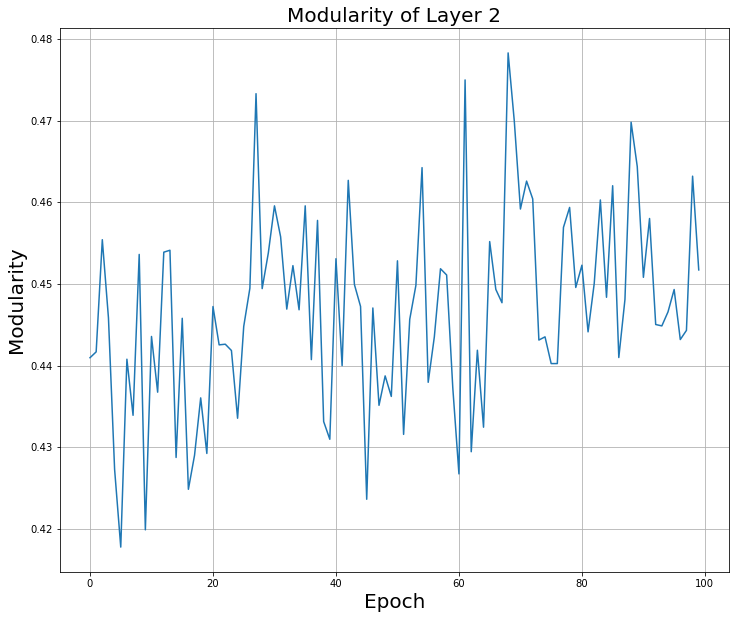

In [87]:
plt.figure(figsize=(12,10))
plt.plot(modularity_layer2)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Modularity", fontsize = 20)
plt.title("Modularity of Layer 2", fontsize = 20)
plt.grid(True)
plt.show()

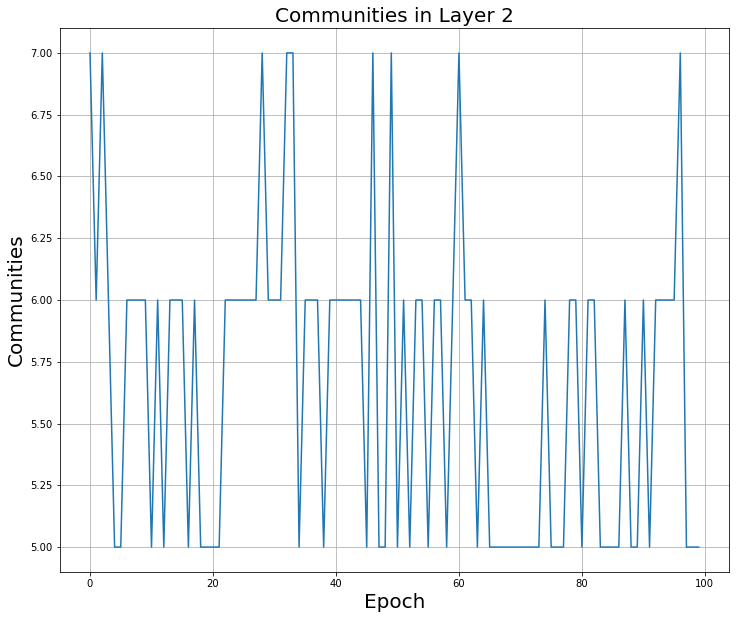

In [88]:
plt.figure(figsize=(12,10))
plt.plot(communities_layer2)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Communities", fontsize = 20)
plt.title("Communities in Layer 2", fontsize = 20)
plt.grid(True)
plt.show()

# Modularity Function - Change Over Time - Layer 3

In [89]:
# Correlation matrix for every epoch of Hidden Layer 1
corr_mat_epoch_l3 = []
for n in range(numEpochs):
    df = pd.DataFrame(cbk6.weights[n], index = index_neuron , columns = weights_neuron)
    df = df.transpose()
    df = df.corr()
    df = df.mask(np.tril(np.ones(df.shape)).astype(np.bool_), 0) 
    corr_mat_epoch_l3.append(df)

In [90]:
# finding modularity for each matrix 
modularity_layer3 = []
communities_layer3 = []
for n in range(numEpochs):
    cor_mat = corr_mat_epoch_l3[n]
        # creating edge list 
    links = cor_mat.stack().reset_index()
    links.columns = ['Neuron A', 'Neuron B', 'Value'] 
    # drop the rows with 0 in Value 
    rows_zero = links.loc[links['Value'] == 0.0]
    links = links.drop(rows_zero.index)

    # save values with correlation more than 0.2
    links_filtered=links.loc[ (links['Value'] > abs(0.2)) ]

    # make the graph 
    G=nx.from_pandas_edgelist(links_filtered, 'Neuron A', 'Neuron B')
    pos = nx.spring_layout(G) 

    # calculate modularity 
    # Detect communities using Louvain algorithm
    partition = community_louvain.best_partition(G)
    
    # list of communities
    new_dict = {}
    for key, value in partition.items():
        new_dict.setdefault(value, []).append(key)
    # Convert the dictionary of lists into a list of lists
    result = list(new_dict.values())
    
    communities_layer3.append(len(result))

    modularity = community_louvain.modularity(partition, G)
    
    modularity_layer3.append(modularity)

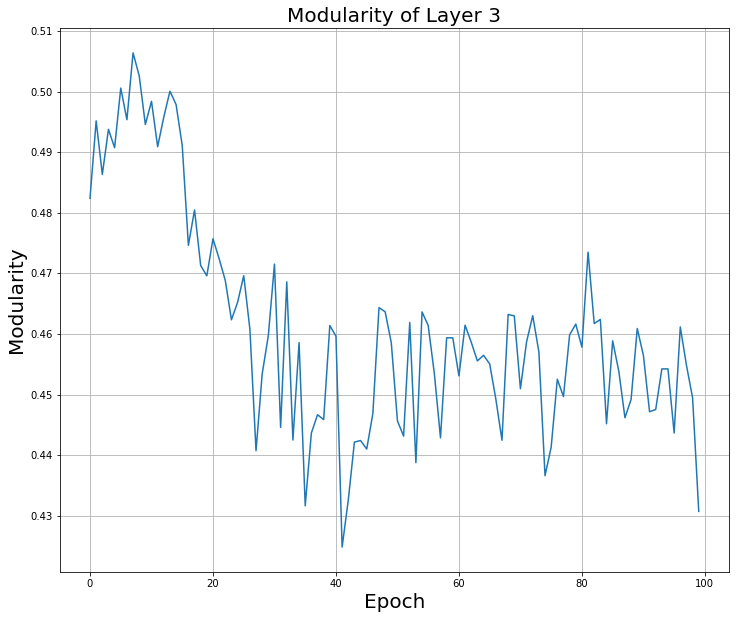

In [91]:
plt.figure(figsize=(12,10))
plt.plot(modularity_layer3)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Modularity", fontsize = 20)
plt.title("Modularity of Layer 3", fontsize = 20)
#ax2 = plt.twiny()
#ax2.plot(pd.Series(np.random.uniform(10, 20, size=10)), color='r')
#ax2.grid(None)
plt.grid(True)
plt.show()

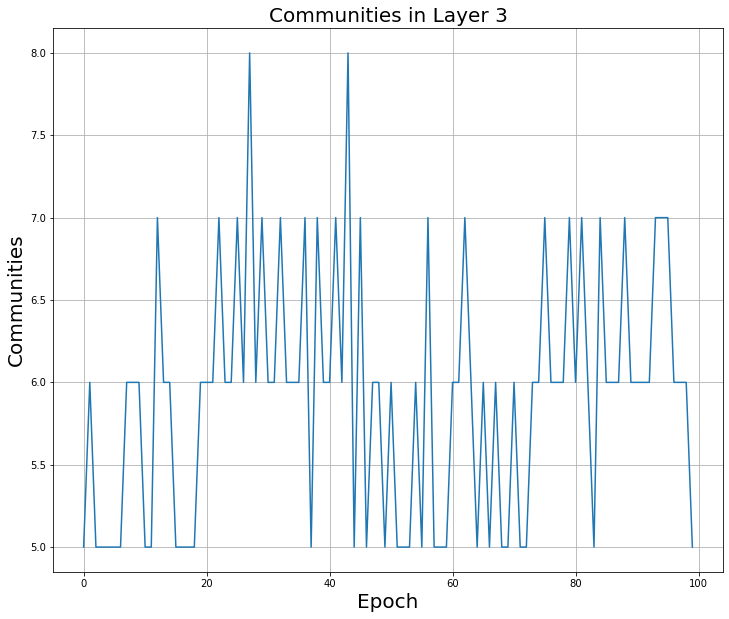

In [92]:
plt.figure(figsize=(12,10))
plt.plot(communities_layer3)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Communities", fontsize = 20)
plt.title("Communities in Layer 3", fontsize = 20)
plt.grid(True)
plt.show()

# Modularity Function - Change over time - all layers 

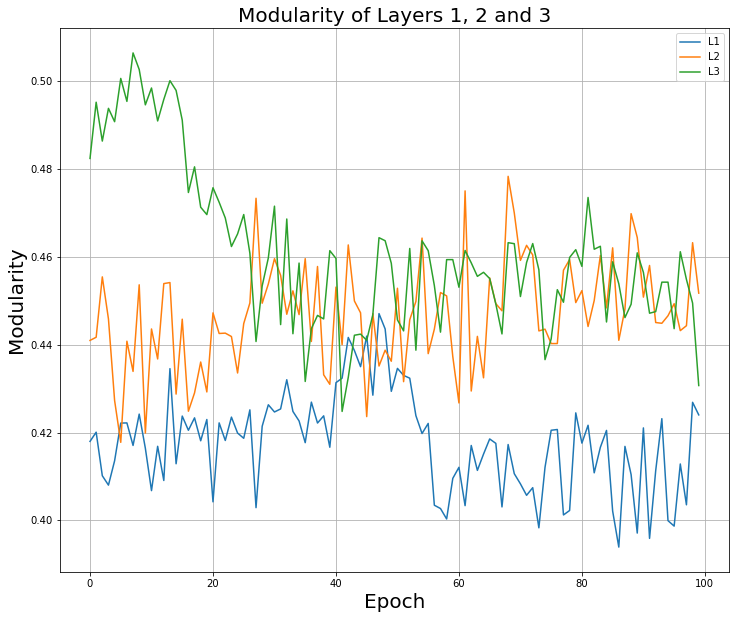

In [93]:
plt.figure(figsize=(12,10))
plt.plot(modularity_layer1)
plt.plot(modularity_layer2)
plt.plot(modularity_layer3)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Modularity", fontsize = 20)
plt.title("Modularity of Layers 1, 2 and 3", fontsize = 20)
plt.legend(['L1', 'L2', 'L3'])
plt.grid(True)
plt.show()

# Number of Communities for layers in every epoch

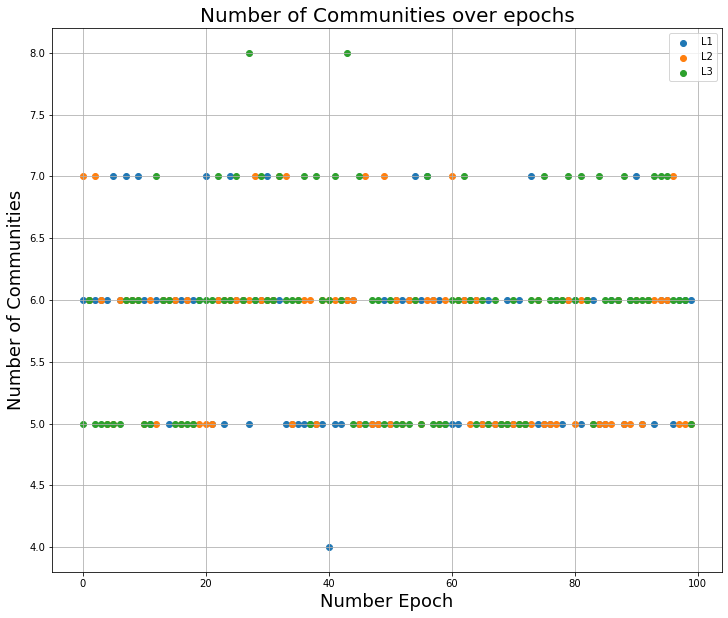

In [103]:
plt.figure(figsize=(12, 10))
plt.scatter(range(100), communities_layer1)
plt.scatter(range(100), communities_layer2)
plt.scatter(range(100), communities_layer3)
plt.xlabel('Number Epoch', fontsize = 18)
plt.ylabel('Number of Communities', fontsize = 18)
plt.title('Number of Communities over epochs', fontsize= 20)
plt.legend(['L1', 'L2', 'L3'])
plt.grid(True)
plt.show()

# Mann Whitney Test 

In [97]:
from scipy.stats import mannwhitneyu 

In [98]:
statistic_12, pvalue_12 = mannwhitneyu(modularity_layer1[:5], modularity_layer2[:5], alternative = 'two-sided')
if pvalue_12 <= 0.05:
    print("Reject Null Hypothesis \nThat is: The means are not equal")
else:
    print("Accept Null Hypothesis \nThat is: The means are equal")
print("Pvalue: " + str(pvalue_12))

Reject Null Hypothesis 
That is: The means are equal
Pvalue: 0.007936507936507936


In [99]:
statistic_23, pvalue_23 = mannwhitneyu(modularity_layer2, modularity_layer3, alternative = 'two-sided')
if pvalue_23 <= 0.05:
    print("Reject Null Hypothesis \nThat is: The means are not equal")
else:
    print("Accept Null Hypothesis \nThat is: The means are equal")
print("Pvalue: " + str(pvalue_23))

Reject Null Hypothesis 
That is: The means are equal
Pvalue: 4.548082473398605e-09


In [100]:
statistic_31, pvalue_31 = mannwhitneyu(modularity_layer3, modularity_layer1, alternative = 'two-sided')
if pvalue_31 < 0.05:
    print("Reject Null Hypothesis \nThat is: The means are equal")
else:
    print("Dont Accept Null Hypothesis \nThat is: The means are not equal")
print("Pvalue: " + str(pvalue_31))

Reject Null Hypothesis 
That is: The means are equal
Pvalue: 4.460281771668419e-33


# Statistical Test of Modularities btw L1 and L2

In [50]:
# Man - Whitney Test 
# Threshold - 0.5 
